# Set up Google Colab

This means mounting drive and importing

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2
%aimport -tensorflow

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


# Train

Currently we have two ways of doing this, one with a keras Sequence and one with ImageDataGenerator. It isn't obvious which of these is better, 

the Sequence is:
- Less opaque
- Easier to debug (for me at least)
- Pretty straight forward and customizable

And the ImageDataGenerator is:
- Fewer lines (sort of)
- It has built in data augmentation
- Faster (since its all written by pros)
- Doesn't really seem super well suited to like semantic segmentation, but its probably fine

So for now, I'm spending most of my time with the Sequence approach, but both are good

## Train With Sequence

**Importing the names of all the files we want to train with**

In [2]:
import os
import numpy as np

input_dir = 'data/train_nouveaux_256/image'
input_names = np.array([])
for fname in np.sort(os.listdir(input_dir)):
    if fname.endswith('.png') and np.char.find(fname, '_'):
        input_names = np.append(input_names, os.path.join(input_dir, fname))

label_dir = 'data/train_nouveaux_256/label'
label_names = np.array([])
for fname in np.sort(os.listdir(label_dir)):
    if fname.endswith('.png') and np.char.find(fname, '_'):
        label_names = np.append(label_names, os.path.join(label_dir, fname))

print(f"Found {len(input_names)} samples")

Found 299 samples


**Making Sequence**

In [3]:
from src.grain_sequence import GrainSequence
import random

validation_samples = 30
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

Training set size: 269, 53 batches
Validation set size: 30, 6 batches


In [7]:
from src import unet
from tensorflow import keras

model = unet.unet(input_size = (256, 256, 1))
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=66, 
    callbacks=[model_checkpoint], 
    validation_data=valid_gen,
    workers=2
)

Epoch 1/66


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


53/53 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9446
Epoch 1: saving model to unet_grain.hdf5
53/53 [==============================] - 16s 274ms/step - loss: 0.2396 - accuracy: 0.9446 - val_loss: 0.2161 - val_accuracy: 0.9469
Epoch 2/66
53/53 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9448
Epoch 2: saving model to unet_grain.hdf5
53/53 [==============================] - 12s 227ms/step - loss: 0.2250 - accuracy: 0.9448 - val_loss: 0.2086 - val_accuracy: 0.9469
Epoch 3/66
53/53 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9448
Epoch 3: saving model to unet_grain.hdf5
53/53 [==============================] - 12s 227ms/step - loss: 0.2045 - accuracy: 0.9448 - val_loss: 0.1922 - val_accuracy: 0.9469
Epoch 4/66
53/53 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9448
Epoch 4: saving model to unet_grain.hdf5
53/53 [==============================] - 13s 237ms/step - loss: 0.1925 - ac

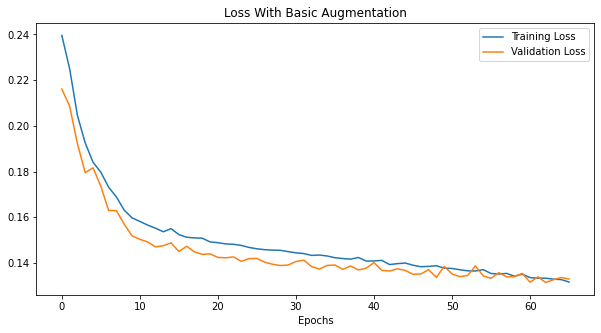

In [25]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Basic Augmentation")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

## Train with data generator

In [ ]:
from tensorflow import keras
from skimage import io
import numpy as np

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
save_to_dir = 'data/train/aug'
myGene = data.trainGenerator(4,'data/train','image','label',data_gen_args, save_to_dir = save_to_dir, target_size = (256, 256))

model = Model.unet(input_size = (256, 256, 1))
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=False)
model.fit_generator(myGene, steps_per_epoch=50, epochs=3, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Epoch 1/3
50/50 [==============================] - ETA: 0s - loss: 0.1360 - mae: 0.1532
Epoch 00001: saving model to unet_grain.hdf5
50/50 [==============================] - 218s 4s/step - loss: 0.1360 - mae: 0.1532
Epoch 2/3
50/50 [==============================] - ETA: 0s - loss: 0.0815 - mae: 0.1217
Epoch 00002: saving model to unet_grain.hdf5
50/50 [==============================] - 205s 4s/step - loss: 0.0815 - mae: 0.1217
Epoch 3/3
38/50 [=====================>........] - ETA: 49s - loss: 0.0819 - mae: 0.1201

### Investigate Filters

In [ ]:
# lil snippet to try to view the filters
import numpy as np
from skimage import io
model = Model.unet()
model.load_weights("unet_grain.hdf5")
weights = model.get_weights()
filters = np.array(weights[0])

for i in range(64):
    filt = np.zeros((3,3))
    filt[0,0] = filters[0][0][0][i]
    filt[0,1] = filters[0][1][0][i]
    filt[0,2] = filters[0][2][0][i]

    filt[1,0] = filters[1][0][0][i]
    filt[1,1] = filters[1][1][0][i]
    filt[1,2] = filters[1][2][0][i]
    
    filt[2,0] = filters[2][0][0][i]
    filt[2,1] = filters[2][1][0][i]
    filt[2,2] = filters[2][2][0][i]

    io.imshow(filt)
    io.show()

# Test 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 131s 10s/step
Saving to data/test 2-11/(528, 528)/0_predict.png
Min: 93.60790252685547, Max: 255.0, Shape: (528, 528, 1)



/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


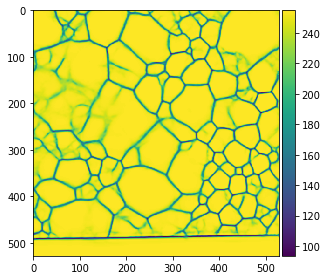

Saving to data/test 2-11/(528, 528)/1_predict.png
Min: 94.82383728027344, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/10_predict.png
Min: 91.40515899658203, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/11_predict.png
Min: 84.8229751586914, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/12_predict.png
Min: 89.22530364990234, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/2_predict.png
Min: 92.02287292480469, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/3_predict.png
Min: 103.71836853027344, Max: 254.99993896484375, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/4_predict.png
Min: 103.10106658935547, Max: 255.0, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/5_predict.png
Min: 101.23432922363281, Max: 254.99993896484375, Shape: (528, 528, 1)

Saving to data/test 2-11/(528, 528)/6_predict.png
Min: 90.24498748779297, Max: 255.0, Shape: (528, 528, 1

In [51]:
import os
from skimage import io, transform
from time import time
import numpy as np

test_dir = 'data/test 2-11/'
target_size = (528,528)

save_dir = f'{test_dir}{target_size}/'
save_suf = '_predict'


def test_img_gen(test_paths, target_size=(256,256)):
    for ind, path in enumerate(test_paths):
        img = io.imread(path)
        if len(img.shape) > 2:
            img = img[:,:,0]
        if img.shape != target_size:
            img = transform.resize(img, target_size)

        img -= img.min()
        img = img.astype('float32') / np.ptp(img)
        img = np.expand_dims(img, 0)
        yield img

test_names = np.array([])
for fname in np.sort(os.listdir(test_dir)):
    if fname.endswith('.png') and np.char.find(fname, '_') == -1:
        test_names = np.append(test_names, os.path.join(test_dir, fname))

test_set = test_img_gen(test_names, target_size=target_size)

model = unet.unet(input_size=(target_size + (1,)))
model.load_weights("results/nouveaux256_aug_b5-s53-e66.hdf5")

results = 255 * model.predict(test_set, steps=len(test_names), verbose=1)

for ind, result in enumerate(results):
    fname = test_names[ind].split('/')[-1]
    save_path = f'{save_dir}{fname[:-4]}{save_suf}.png'
    print(f"\nSaving to {save_path}")
    print(f"Min: {np.min(result)}, Max: {np.max(result)}, Shape: {result.shape}")
    io.imsave(save_path, result[:,:,0].astype('uint8'))
    if ind == 0:
        io.imshow(result[:, :, 0])
        io.show()

# Post Processing

## Threshold and Skeletonizing

This next thing is just to visualize what the processing is doing before applying it to all the images

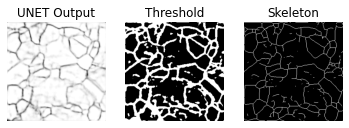

In [ ]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/testerino/0_predict.png', thresh=250, verbose=True)

**This is to apply this processing to all the boundaries**

In [ ]:
if 'test_n' not in locals():
    test_n = 29
    test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

## Overlay 

In [ ]:
from skimage import io, transform
import numpy as np
import os

if 'test_n' not in locals():
    test_n = 1
    test_dir = 'data/test/'

for i in range(test_n):
    i = i + 1
    raw_img = io.imread(f'{test_dir}0{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255
    if os.path.isfile(f'{test_dir}key/{i}.png'):
        ht_img = io.imread(f'{test_dir}key/{i}.png')
        ht_img = 255 - (255 * transform.resize(ht_img, raw_img.shape, anti_aliasing=False))
        fusion_img[ht_img > 0, 1] = 255
#        io.imshow(fusion_img)
#        io.show()

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 


FileNotFoundError: ignored

# Model Evaluation Tools

## Intersection Over Union (IOU)
This test should find what percent of the predicted grain boundary (pred) matched the actual hand traced boundary (test)

`iou_test.find_iou(pred, ref)` 
This function finds the mean IOU between `pred` and `ref`. It does this by matching each grain in a traced (`ref`) image with a grain in the corresponding predicted (`pred`) image and calculating the Jaccard similarity index between them. It then takes the mean of all these Jaccard indicies to find the final mean iou of an image.

In [ ]:
from skimage import io, transform
import numpy as np
import iou_test
import importlib, os
importlib.reload(iou_test)

if 'test_n' in locals():
    test_dir = 'data/test/'
    traced_dir = 'data/test/key/'

traced_dir = test_dir + 'key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

results = np.array([], dtype=np.float64)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png') / 255
    ml_img = 1 - ml_img
#    ml_img = io.imread(test_dir + key + '_predict.png') / 255
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)
    key_img = key_img > 0.9
    
    iou = iou_test.find_iou(ml_img, key_img, verbose=False)
    results = np.append(results, iou)
    print(f' - img {key} \t Mean IOU: {iou}')
    
print(f'\nMean Mean IOU = {np.mean(results)}\nMedian Mean IOU = {np.median(results)}\n\n')
print(f'Max Mean IOU = {np.max(results)}, Min Mean IOU = {np.min(results)}')


 - img 0 	 Mean IOU: 0.6897960320932874
 - img 1 	 Mean IOU: 0.6918237807413546
 - img 10 	 Mean IOU: 0.32937398306008037
 - img 11 	 Mean IOU: 0.4090040275747048
 - img 12 	 Mean IOU: 0.3772879304429595
 - img 13 	 Mean IOU: 0.2836940215242354
 - img 14 	 Mean IOU: 0.263733829255234
 - img 15 	 Mean IOU: 0.3609622702541213
 - img 16 	 Mean IOU: 0.3174240846292632
 - img 17 	 Mean IOU: 0.13929159806323452
 - img 18 	 Mean IOU: 0.29501815187293223
 - img 19 	 Mean IOU: 0.3441311127996548
 - img 2 	 Mean IOU: 0.5405584809756075
 - img 20 	 Mean IOU: 0.3092728479491392
 - img 21 	 Mean IOU: 0.0923450719252461
 - img 22 	 Mean IOU: 0.35390273997218114
 - img 23 	 Mean IOU: 0.32514641024161567
 - img 24 	 Mean IOU: 0.3260055477566883
 - img 25 	 Mean IOU: 0.3415242557556229
 - img 26 	 Mean IOU: 0.2908972545854925
 - img 27 	 Mean IOU: 0.1339033245176248
 - img 28 	 Mean IOU: 0.19717508171493314
 - img 3 	 Mean IOU: 0.4149391995491761
 - img 4 	 Mean IOU: 0.3199635288446575
 - img 5 	 Mean 

## Chi2

In [ ]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

chi2_dtype = [('img', (np.str_, 10)), ('chi2', np.float64), ('avg_chi2', np.float64)]
results = np.array([], dtype=chi2_dtype)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img
    
    result = find_chi2(ml_img, key_img, out_dict=True)
    results = np.append(results, \
                np.array([(key, result["chi2"], result["avg_chi2"])], dtype=chi2_dtype))
    print(f'- img: {key} \t chi2: {result["chi2"]} \t avg_chi2: {result["avg_chi2"]} \t median_r2: {result["median_r2"]}')

print(f'\nAverage chi2: {np.mean(results["chi2"])}\nAverage avg_chi2: {np.mean(results["avg_chi2"])}\nMedian chi2: {np.median(results["chi2"])}')
print(f'Max chi2: {np.max(results["chi2"])}\nMin chi2: {np.min(results["chi2"])}')

## Chi2 Alignment

In [ ]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()
